# Comparing axis-aligned random forest versus oblique forest on simulation datasets
The previous notebook conducted visual analysis using `Iris` dataset. Here we extend our analysis using custom simulation dataset: `sparse_parity`, from which OF demonstrates significant performance improvement over RF. Additionally, we prepared two toy datasets from scikit-learn dataset module, `make_hastie_10_2` and `make_gaussain_quantiles`, that also simulates high-dimentionality problems. OF also outperforms RF on these datasets but in lesser degree.

### Environment
- Python 3.8.13
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquepr)

In [1]:
!python --version

Python 3.8.13


### Import packages

In [2]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.datasets import make_hastie_10_2, make_gaussian_quantiles #imported in case of testing
from sklearn.ensemble import RandomForestClassifier, ObliqueRandomForestClassifier

import os
import time
import itertools
from tqdm import tqdm
import _pickle as cPickle
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random_state = 123456

sklearn.__version__

'1.2.dev0'

In [3]:
today = str(datetime.now().date())
today

'2022-06-29'

### Generating sparse parity simulation data
Sparse parity is a variation of the noisy parity problem, which itself is a multivariate generalization of the noisy XOR problem. This is a binary classification task in high dimensions. The simulation will generate uniformly distributed `n_samples` number of sample points in the range of -1 and +1 with `p` number of features. `p*` is a parameter used to limit features that carry information about the class. The informative binary label is then defined as 1 if there are odd number of the sum of data `X` across first `p*` features that are greater than 0, otherwise the label is defined as 0. The simulation is further detailed in our [publication](https://epubs.siam.org/doi/epdf/10.1137/1.9781611974973.56).

In [4]:
def sparse_parity(n_samples, p=20, p_star=3, random_seed=None, **kwarg):
 
    if random_seed: 
        np.random.seed(random_seed)

    X = np.random.uniform(-1, 1, (n_samples, p))
    y = np.zeros(n_samples)

    for i in range(0, n_samples):
        y[i] = sum(X[i, :p_star] > 0) % 2;

    return X, y

In [5]:
def get_sample(func, n, m=None, o=None):
    k = {}

    np.random.seed(random_state)

    if m: k['noise'] = m
    if o: k['n_features'] = o

    k['n_samples'] = n
    k['random_state'] = random_state # random_state for classifiers

    X, y = func(**k)

    return X, y

def get_scores(X, y, max_features, max_depth, random_state, n_cv, n_repeats):

    clfs = [
        RandomForestClassifier(max_features=max_features, max_depth=max_depth, random_state=random_state),
        ObliqueRandomForestClassifier(max_features=max_features, max_depth=max_depth, random_state=random_state)
    ]

    tmp = []

    for i, clf in enumerate(clfs):

        # if i == 0 and isinstance(max_features, int):
            # if max_features > X.shape[1]:
            #     tmp.append(np.zeros(n_cv * n_repeats))
            #     continue

        cv = RepeatedKFold(n_splits=n_cv, n_repeats=n_repeats, random_state=random_state)
        test_score = cross_validate(estimator=clf, X=X, y=y, cv=cv, scoring='accuracy')
        
        tmp.append(
            test_score['test_score']
        )

    # print(f'max_feature: {max_features} | max_depth: {max_depth}')

    return tmp

In [6]:
X1,y1 = sparse_parity(n_samples=500,p=2,p_star=2)
X2,y2 = sparse_parity(n_samples=5000,p=3,p_star=3)
X1.shape, y1.shape, X2.shape, y2.shape

((500, 2), (500,), (5000, 3), (5000,))

### Visualization of sparse parity at low dimension
At `p=2`, sparse partiy becomes noisy XOR problem (left). Adding one more dimension makes the 3D XOR problem (right).

Text(0.5, 0.92, 'Sparse Parity at p=3')

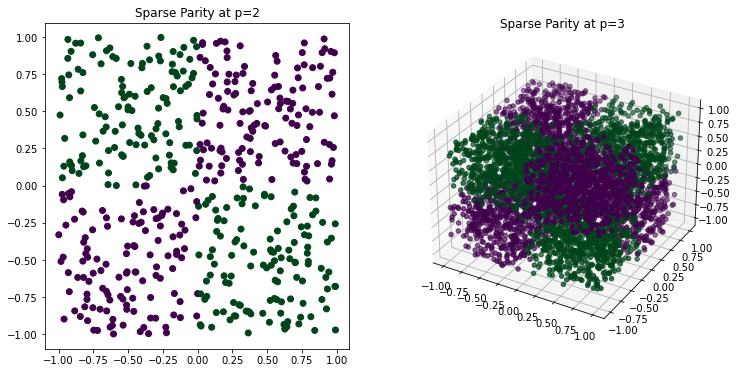

In [7]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(X1[:,0],X1[:,1], c=y1, cmap='PRGn')
ax.set_title('Sparse Parity at p=2')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X2[:,0],X2[:,1],X2[:,2], c=y2, cmap='PRGn')
ax.set_title('Sparse Parity at p=3')

In [8]:
def run_experiment(n_repeat, n_cv, random_state):
    n_samples = [100, 1000, 10000]
    accs = []
    
    clf_kwarg = {
        'max_features': None,
        'max_depth': 10,
        'random_state': random_state,
        'n_repeats': n_repeat,
        'n_cv': n_cv
    }

    for n_sample in tqdm(n_samples):
        data_args = [
            # name of dataset, function, n_sample, noise, n_features
            ['sparse_parity', sparse_parity, n_sample],

            #sklearn toy datasets can also be test by decommenting these lines
            # ['make_gaussian_quantiles', make_gaussian_quantiles, n_sample, None, 5], 
            # ['make_hastie_10_2', make_hastie_10_2, n_sample]
        ]

        for arg in data_args:
            X, y = get_sample(*arg[1:])
            
            for max_feature in ['sqrt', X.shape[1], X.shape[1]*2]: #max_features
                clf_kwarg['max_features'] = max_feature

                acc = get_scores(X, y, **clf_kwarg)
                accs.append([arg[0], n_sample, n_repeat, max_feature, clf_kwarg['max_depth'], random_state] + acc)

    df = pd.DataFrame(accs, columns=['dataset', 'n_sample', 'n_repeat', 'max_feature', 'max_depth', 'random_state', 'RF', 'OF'])
    df['delta'] = df.apply(lambda x: x.OF-x.RF, axis=1)

    # with open('dat/simulation_notebook_rf_vs_of.pkl', 'wb') as f:
    #     cPickle.dump(df, f)

    return df

In [9]:
df = run_experiment(n_repeat=1, n_cv=3, random_state=random_state)

100%|██████████| 3/3 [01:34<00:00, 31.53s/it]


In [10]:
df2 = df.copy()
df2['max_depth'] = df2.max_depth.replace(np.nan, 'inf')
df2 = df2.explode(['RF','OF','delta'])[['dataset','n_sample','max_feature','max_depth','RF','OF','delta']]
df2.head()

,dataset,n_sample,max_feature,max_depth,RF,OF,delta
0,sparse_parity,100,sqrt,10,0.441176,0.411765,-0.029412
0,sparse_parity,100,sqrt,10,0.363636,0.424242,0.060606
0,sparse_parity,100,sqrt,10,0.333333,0.424242,0.090909
1,sparse_parity,100,20,10,0.323529,0.294118,-0.029412
1,sparse_parity,100,20,10,0.424242,0.363636,-0.060606


In [11]:
dset = df2.dataset.unique()
max_depth = 10

# for i, d in enumerate(dset):
#     df_new = df2.query(f'dataset == "{d}" and max_depth == {max_depth}')
#     n_feature = df_new[~(df_new.max_feature == 'sqrt')].max_feature.min() #minimum numeric max_feature

#     df_mf1 = df_new.query(f'max_feature == {n_feature}') #RF max_feature to be compared with OF 2x, 3x max_feature

#     for ns in df_mf1.n_sample.unique(): #n_sample
#         for mf_not_1 in df_new.max_feature.unique():
#             if mf_not_1 in [n_feature, 'sqrt']:
#                 continue

#             indexing = (df2.dataset==d) & (df2.max_depth==max_depth) & (df2.n_sample==ns) & (df2.max_feature==mf_not_1)
#             df2.loc[indexing, ['RF']] = df_mf1.query(f'n_sample == {ns}').RF.tolist()

df2['delta'] = df2.apply(lambda x: x.OF-x.RF, axis=1)

In [12]:
df2.head()

,dataset,n_sample,max_feature,max_depth,RF,OF,delta
0,sparse_parity,100,sqrt,10,0.441176,0.411765,-0.029412
0,sparse_parity,100,sqrt,10,0.363636,0.424242,0.060606
0,sparse_parity,100,sqrt,10,0.333333,0.424242,0.090909
1,sparse_parity,100,20,10,0.323529,0.294118,-0.029412
1,sparse_parity,100,20,10,0.424242,0.363636,-0.060606


### Base Model Result
Three settings of the `max_features` are compared and their corresponding delta accuracy between OF and RF is shown as a box plot. After a meaningful number of data is simulated (i.e., `n_samples` > 10^4), OF starts to outperform RF significantly across all `max_features` settings especially when `max_feature` is greater than or equal to `n_features`.

The most likely reason for this is because OF should be more robust to high-dimensional noise. Moreover, due to the ability to sample more variable splits (i.e. `max_features` can be greater than `n_features` compared to RF), then we expect to see an increase in performance when we are willing to use computational power to sample more splits.

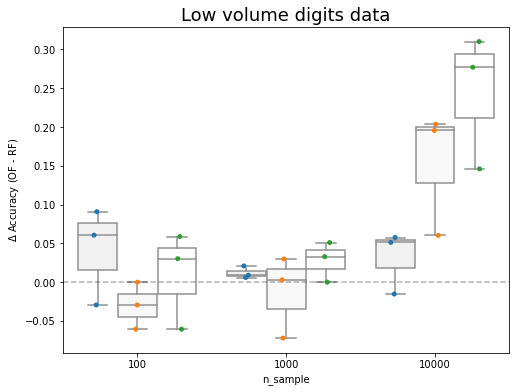

In [13]:
dset = df2.dataset.unique() #get the list of dataset loaded

ncols = 1

fig, ax = plt.subplots(figsize=(8,6))

sns.stripplot(data=df2, x='n_sample', y='delta', hue='max_feature', ax=ax, dodge=True)
sns.boxplot(data=df2, x='n_sample', y='delta', ax=ax, hue='max_feature', color='white')

ax.set_ylabel(r'$\Delta$ Accuracy (OF - RF)')
ax.set_title('Low volume digits data', fontsize=18);
ax.axhline(y=0, ls='--', color='black', alpha=0.3);
ax.legend([],[], frameon=False);

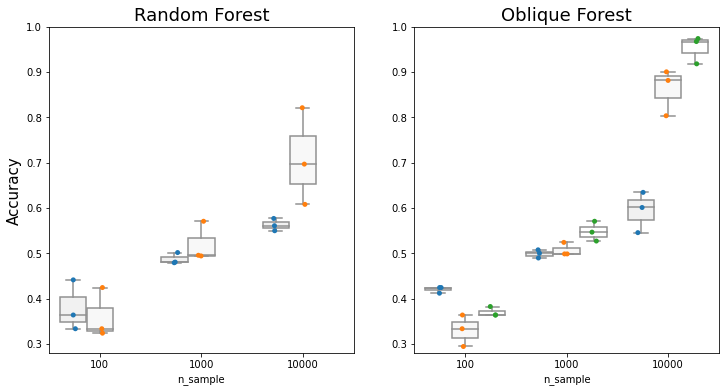

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

df_new2 = df2.copy()
df_new2.loc[df_new2.max_feature==40,'RF'] = 2 #remove 2x mtry from RF

for i, j in enumerate(['RF', 'OF']):
    g = sns.boxplot(data=df_new2, x='n_sample', y=j, ax=ax[i], hue='max_feature', color='white')
    h = sns.stripplot(data=df_new2, x='n_sample', y=j, ax=ax[i], hue='max_feature', dodge=True)

ax[0].set_ylabel(r'Accuracy', fontsize=15)
ax[1].set_ylabel('', fontsize=15)
ax[0].set_title('Random Forest', fontsize=18);
ax[1].set_title('Oblique Forest', fontsize=18);

for nc in range(2):
    ax[nc].set_ylim(0.28,1.0)
    ax[nc].legend([],[], frameon=False) #temp legend fix to remove double legends

### Optimized Model Comparison via Grid Searching
The following is the optimized result from grid searching best paramters of three features: `max_features`, `n_estimators`, `max_depth`

In [15]:
# number of grid searching iteration
n_gridCV = 20

In [16]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'max_features': ['sqrt', 'log2', None, 40],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None]
}

df_cv = pd.DataFrame()
feat_cols = list(params.keys())+['mean_test_score','clf','mean_fit_time',
                                'std_fit_time','mean_score_time',
                                'std_score_time','params'
                                ]
clfs = [
    RandomForestClassifier(random_state=random_state),
    ObliqueRandomForestClassifier(random_state=random_state)
]

X, y = get_sample(sparse_parity, 10000)

for clf, clf_lab in zip(clfs, ['RF', 'OF']):
    t_i = time.time()

    search = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter=n_gridCV, random_state=random_state)
    search.fit(X, y)
    print(f'Grid Searching {n_gridCV} parameter combinations took {int(time.time()-t_i)} seconds for {clf_lab} algorithm')
    
    df_tmp = pd.DataFrame(search.cv_results_)
    df_tmp.columns = [i.replace('param_','') for i in df_tmp.columns]
    df_tmp['clf'] = clf_lab
    # df_tmp.fillna('None', inplace=True)
    df_tmp['mean_test_score'] = df_tmp.apply(lambda x: round(x['mean_test_score'], 3), axis=1)
    df_cv = pd.concat([df_cv, df_tmp])

Grid Searching 20 parameter combinations took 1209 seconds for RF algorithm
Grid Searching 20 parameter combinations took 1144 seconds for OF algorithm


#### Refitting base tree with parameters from each iteration of grid searching

In [17]:
def get_tree_size(df, random_state, savefile=True):

    N = df.shape[0]
    tree_size = []
    df.reset_index(drop=True, inplace=True)

    t_i = time.time()

    for i in range(N):
        
        row = df.iloc[i,:]

        if row['clf'] == 'RF':
            clf = RandomForestClassifier(random_state=random_state, **row['params'])
        elif row['clf'] == 'OF':
            clf = ObliqueRandomForestClassifier(random_state=random_state, **row['params'])
        else:
            print('Cannot identify estimator')

        clf.fit(X,y)
        tree_size.append(cPickle.dumps(clf).__sizeof__())

    new_df = pd.concat([df, pd.DataFrame(tree_size, columns=['clf_size'])], axis=1)

    print(f'Refitting trees took {int(time.time()-t_i)} seconds')

    if savefile:
        with open('simulation_runtime_output.pkl', 'wb') as handle:
            cPickle.dump(new_df, handle)

    return new_df

In [18]:
df_size = get_tree_size(df_cv, random_state=random_state)

Refitting trees took 568 seconds


#### Plot score versus performance metrics

In [19]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def bestfit(df, x, y='mean_test_score', clf='RF', degree=1):
    dff = df.query(f'clf == "{clf}"')

    # poly = PolynomialFeatures(degree=degree, include_bias=False)
    # poly_features = poly.fit_transform(dff[x].to_numpy().reshape(-1,1))

    # model = LinearRegression()
    # model.fit(poly_features, dff[y])
    # y_hat = model.predict(poly_features)

    # return y_hat

    y_hat = np.polyfit(dff[x], dff[y], degree)

    return np.poly1d(y_hat)
    

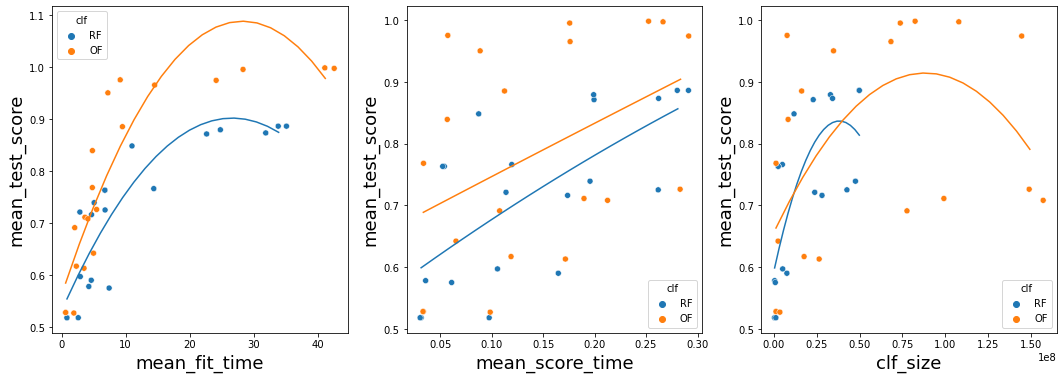

In [20]:
fig, ax = plt.subplots(1,3,figsize=(6*3,6))

x_vars = ['mean_fit_time', 'mean_score_time', 'clf_size']


for idx, x_var in enumerate(x_vars):
    sns.scatterplot(data=df_size,x=x_var, y='mean_test_score', hue='clf', ax=ax[idx])
    ax[idx].set_xlabel(x_var, fontsize=18)
    ax[idx].set_ylabel('mean_test_score', fontsize=18)

    for clf in ['RF', 'OF']:
        tmp_degree = {}
        tmp = df_size.query(f'clf=="{clf}"')[x_var]
        qlow, qhigh = np.quantile(tmp,[0.05,0.95])
        x = np.linspace(qlow, qhigh, 20)

        for degree in [2]:
            model = bestfit(df=df_size, x=x_var, clf=clf, degree=degree)

            tmp_degree[degree] = r2_score(
                    y_true=df_size.query(f'clf=="{clf}"')['mean_test_score'],
                    y_pred=model(x))
                    # y_pred=model)

            # print(f'{tmp_degree[degree]}')

        max_idx = max(tmp_degree, key=tmp_degree.get)
        model = bestfit(df=df_size, x=x_var, clf=clf, degree=max_idx)
        ax[idx].plot(x, model(x))
        ax[idx].locator_params(axis='x', nbins=8)
        
        # ax[idx].plot(x, model)

#### Top 5 `mean_test_score` of each algorithm

In [21]:
df_cv_rf = df_cv[feat_cols[:5]].query('clf == "RF"').sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
df_cv_rf.head()

,max_features,n_estimators,max_depth,mean_test_score,clf
0,None,300,None,0.886,RF
1,40,300,None,0.886,RF
2,40,200,None,0.879,RF
3,40,300,20,0.873,RF
4,None,200,20,0.871,RF


In [22]:
df_cv_of = df_cv[feat_cols[:5]].query('clf == "OF"').sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
df_cv_of.head()

,max_features,n_estimators,max_depth,mean_test_score,clf
0,40,300,20,0.998,OF
1,40,300,None,0.997,OF
2,40,200,None,0.995,OF
3,40,100,10,0.975,OF
4,None,300,None,0.974,OF


### Visualization of parameterized grid search result

In [23]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

fig = px.parallel_categories(
    df_cv_rf.iloc[:,:-1],
    color='mean_test_score'
)
fig.show()

In [24]:
px.parallel_categories(
    df_cv_of.iloc[:,:-1],
    color='mean_test_score'
)

### Appendix
The actual values used to generate the above plots

In [25]:
col_groupby = ['dataset','n_sample','max_feature','max_depth']
dff = df2.groupby(col_groupby).mean()
dff.style.background_gradient(cmap='RdBu_r', vmin=-0.4, vmax=0.4)

In [26]:
df_cv.query('clf == "RF"')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,n_estimators,max_features,max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,clf
0,22.646918,0.885736,0.199471,0.025627,200,None,20,"{'n_estimators': 200, 'max_features': None, 'm...",0.9070,0.9105,0.9065,0.8155,0.8135,0.871,0.045831,5,RF
1,4.663584,0.135863,0.173791,0.001995,200,log2,20,"{'n_estimators': 200, 'max_features': 'log2', ...",0.7445,0.7345,0.7460,0.6910,0.6650,0.716,0.032497,13,RF
2,14.393851,0.917873,0.119577,0.011612,200,None,10,"{'n_estimators': 200, 'max_features': None, 'm...",0.7715,0.8415,0.8410,0.6940,0.6820,0.766,0.068696,7,RF
3,4.244291,0.068494,0.035884,0.000830,100,40,5,"{'n_estimators': 100, 'max_features': 40, 'max...",0.5015,0.5415,0.8230,0.5155,0.5070,0.578,0.123415,16,RF
4,2.845686,0.068876,0.113968,0.003440,100,log2,None,"{'n_estimators': 100, 'max_features': 'log2', ...",0.7300,0.7690,0.7385,0.6975,0.6690,0.721,0.034489,12,RF
5,24.797328,0.812283,0.199115,0.009130,200,40,None,"{'n_estimators': 200, 'max_features': 40, 'max...",0.9030,0.9225,0.9165,0.8255,0.8265,0.879,0.043572,3,RF
6,35.123564,1.569897,0.291191,0.030608,300,40,None,"{'n_estimators': 300, 'max_features': 40, 'max...",0.9070,0.9355,0.9310,0.8395,0.8165,0.886,0.048803,1,RF
7,10.989832,0.224941,0.087425,0.007137,100,None,20,"{'n_estimators': 100, 'max_features': None, 'm...",0.8925,0.8780,0.9075,0.8055,0.7580,0.848,0.057142,6,RF
8,6.762663,0.036905,0.054062,0.001080,100,None,10,"{'n_estimators': 100, 'max_features': None, 'm...",0.7910,0.8005,0.8615,0.7150,0.6475,0.763,0.074211,8,RF
9,5.071598,0.156569,0.195590,0.003029,200,log2,None,"{'n_estimators': 200, 'max_features': 'log2', ...",0.7615,0.7740,0.7465,0.7275,0.6865,0.739,0.030580,10,RF


In [27]:
df_cv.query('clf == "OF"')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,n_estimators,max_features,max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,clf
20,14.524053,0.149707,0.176216,0.002413,200,None,20,"{'n_estimators': 200, 'max_features': None, 'm...",0.9750,0.9545,0.9735,0.9515,0.9690,0.965,0.009801,6,OF
21,3.630349,0.025165,0.189726,0.000436,200,log2,20,"{'n_estimators': 200, 'max_features': 'log2', ...",0.7205,0.7350,0.6935,0.7030,0.7010,0.711,0.015071,12,OF
22,9.495841,0.036798,0.112520,0.001209,200,None,10,"{'n_estimators': 200, 'max_features': None, 'm...",0.8955,0.8605,0.9270,0.8690,0.8725,0.885,0.024028,8,OF
23,4.789607,0.020747,0.033835,0.001132,100,40,5,"{'n_estimators': 100, 'max_features': 40, 'max...",0.7315,0.8925,0.8000,0.7115,0.7040,0.768,0.070915,10,OF
24,2.042032,0.018980,0.107782,0.001827,100,log2,None,"{'n_estimators': 100, 'max_features': 'log2', ...",0.6860,0.6850,0.7105,0.6795,0.6940,0.691,0.010794,14,OF
25,28.338802,0.639313,0.175820,0.002988,200,40,None,"{'n_estimators': 200, 'max_features': 40, 'max...",0.9935,0.9960,0.9955,0.9970,0.9940,0.995,0.001288,3,OF
26,42.580922,0.817236,0.266496,0.006167,300,40,None,"{'n_estimators': 300, 'max_features': 40, 'max...",0.9975,0.9965,0.9965,0.9965,0.9955,0.997,0.000632,2,OF
27,7.222720,0.102423,0.088841,0.002096,100,None,20,"{'n_estimators': 100, 'max_features': None, 'm...",0.9545,0.9330,0.9775,0.9340,0.9510,0.950,0.016263,7,OF
28,4.804741,0.110578,0.056905,0.000938,100,None,10,"{'n_estimators': 100, 'max_features': None, 'm...",0.8140,0.8155,0.9230,0.8370,0.8050,0.839,0.043343,9,OF
29,4.094753,0.046346,0.212610,0.001701,200,log2,None,"{'n_estimators': 200, 'max_features': 'log2', ...",0.7075,0.7125,0.7380,0.6875,0.6950,0.708,0.017376,13,OF
